<a href="https://colab.research.google.com/github/jayainhufs/DL-From-Scratch2/blob/main/20241119_%EB%B0%91%EB%B0%94%EB%8B%A5%EB%B6%80%ED%84%B0_%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94_%EB%94%A5%EB%9F%AC%EB%8B%9D2_3%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 3장 Word2Vec

## 3.1 추론 기반 기법과 신경망

3.1.1 통계 기반 기법의 문제점

> 통계 기반 기법에서는 주변 단어의 빈도를 기반으로 단어를 표현했다.

> 단어의 Co-occurrence Matrix를 만들고, 그 행렬에 SVD를 적용하여 밀집벡터(단어의 분산표현)을 구했다.

> 하지만 이런 방식은 대규모 말뭉치(corpus)를 다룰 때 문제가 발생한다.

> 통계 기반 기법은 말뭉치 전체의 통계(동시발생 행렬과 PPMI 등)를 이용해 단 1회의 처리(SVD 등)만에 단어의 분산 표현을 얻는다. (단, 행렬을 적용하는 시간과 비용이 많이 듦)

> 하지만 신경망을 이용한 추론 기법에서는 미니 배치(학습 데이터의 일부)를 이용해 학습한다.

> 이처럼 신경망은 미니 배치(mini-batch)로 학습하기 때문에 대규모의 말뭉치에서도 학습시킬 수 있다.

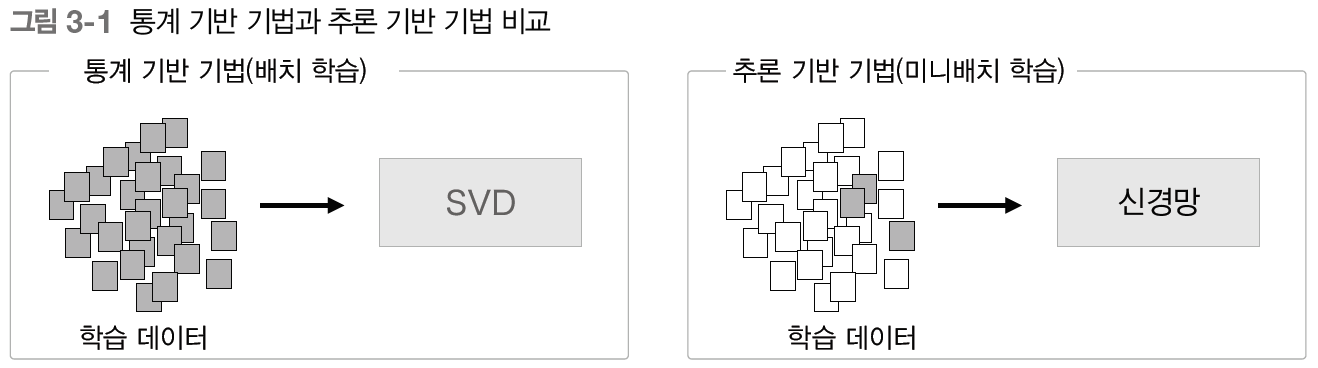

3.1.2 추론 기반 기법 개요

> 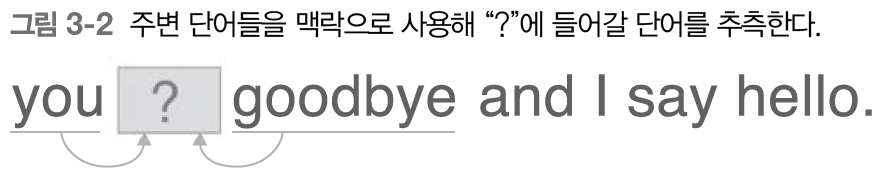

> 추론은 위의 그림과 같이 ?에 들어갈 내용을 추측하는 작업

> 이러한 추론 문제를 반복해서 풀면서, 단어의 출현 패턴을 학습하는 것

> 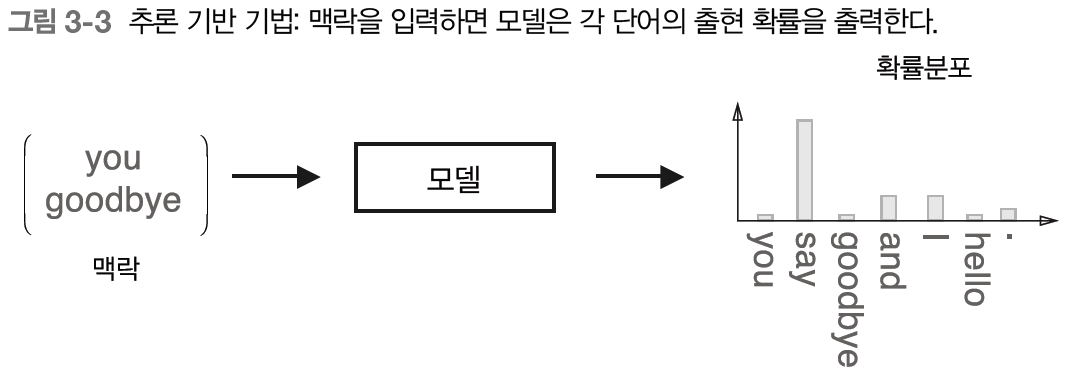

> 모델은 맥락 정보를 입력받아서, 각 단어의 출현 확률을 출력한다.

> 위의 그림은 '모델관점' 에서 바라본 것이다.

3.1.3 신경망에서의 단어 처리

> You, Say와 같은 단어는 있는 그대로 처리 불가

> 따라서, 단어를 **"고정 길이의 벡터"** 로 변환이 필요함

> 고정 길이의 벡터로 변환하는 대표적인 방법은 원-핫 표현(원-핫 벡터)

* 원-핫 벡터

> 벡터의 원소 중 하나만 1이고, 나머지는 0으로 표현함

> 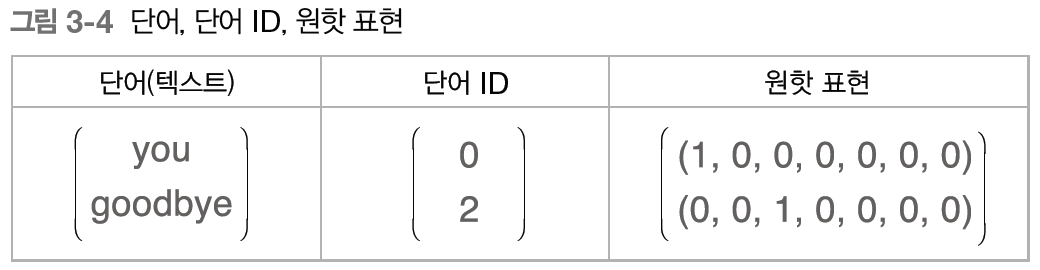

> 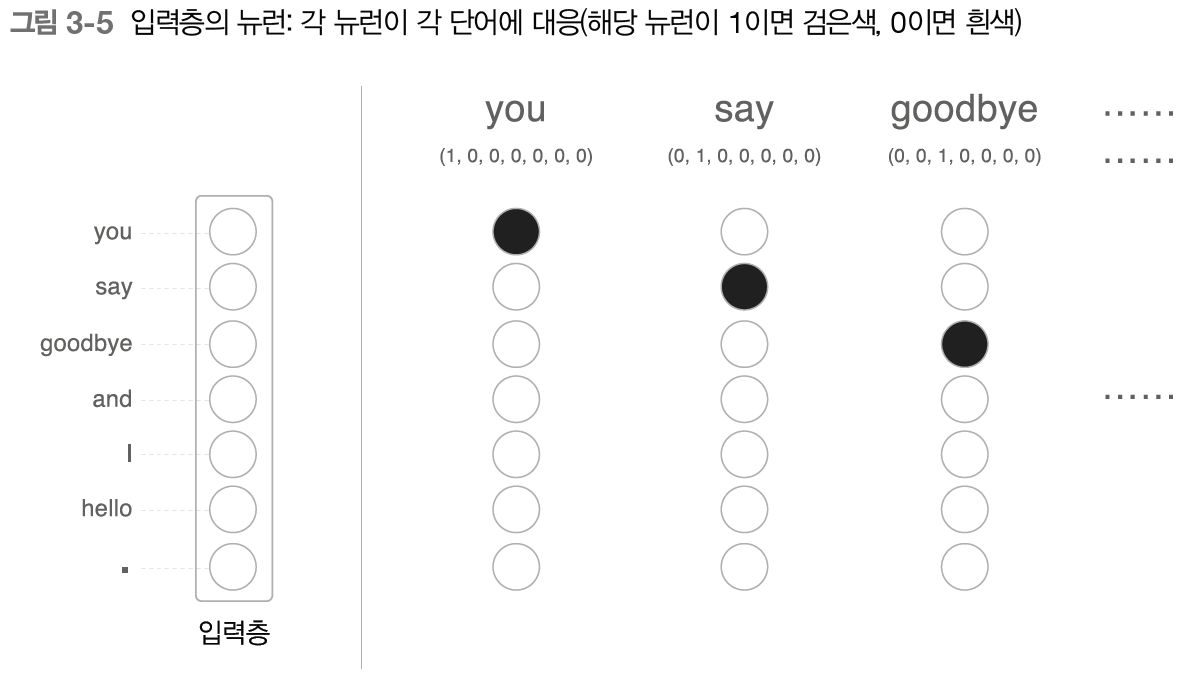

> 위와 같이 원-핫 벡터로 나타낸 단어 벡터를 신경망의 입력으로 주입하고 완전연결계층(FC layer)를 통해 원-핫 벡터로 표현된 단어를 밀집 벡터로 변환해줄 수 있다.

> 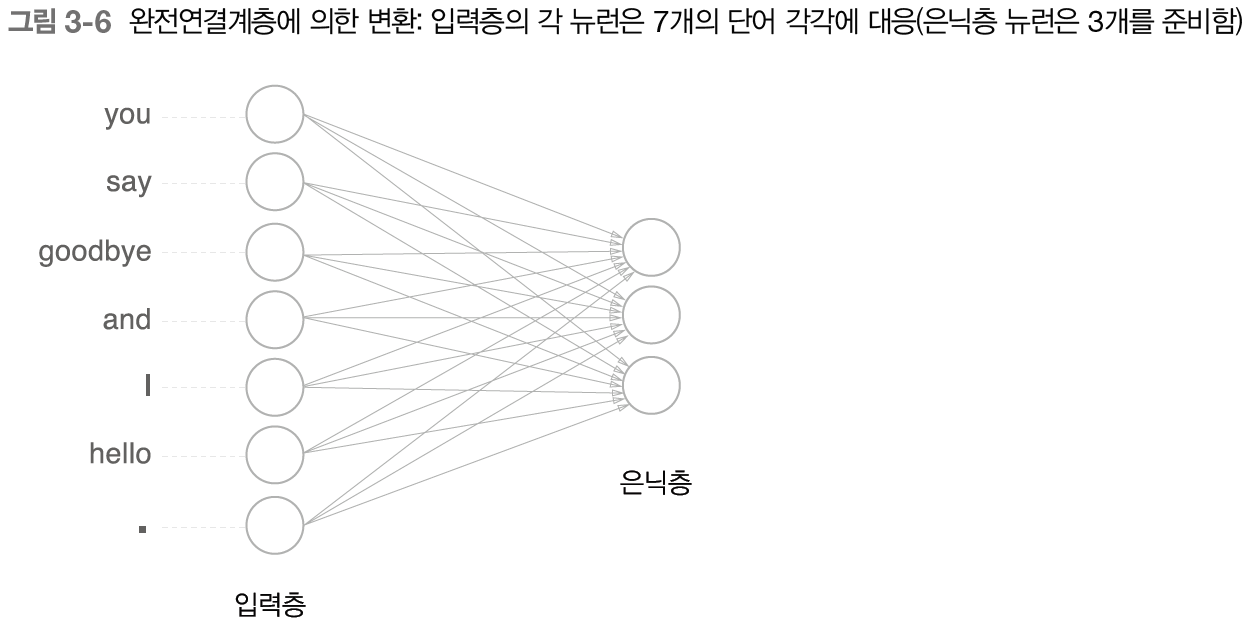

In [1]:
# 완전연결계층에 의한 변환
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])  # 입력 (one-hot)
W = np.random.randn(7, 3)  # 가중치 (랜덤한 값), Word vector
h = np.matmul(c, W)  # 은닉층 노드, matmul >> 행렬곱셈
print(h)

[[-0.61333387  0.59714153  1.39116286]]


> c와 W의 곱은 사실 가중치의 행벡터 하나를 뽑아낸 것과 같다

> c의 벡터가 단어ID에 대응하는 원소만 1이고, 나머지는 0이기 때문에

> 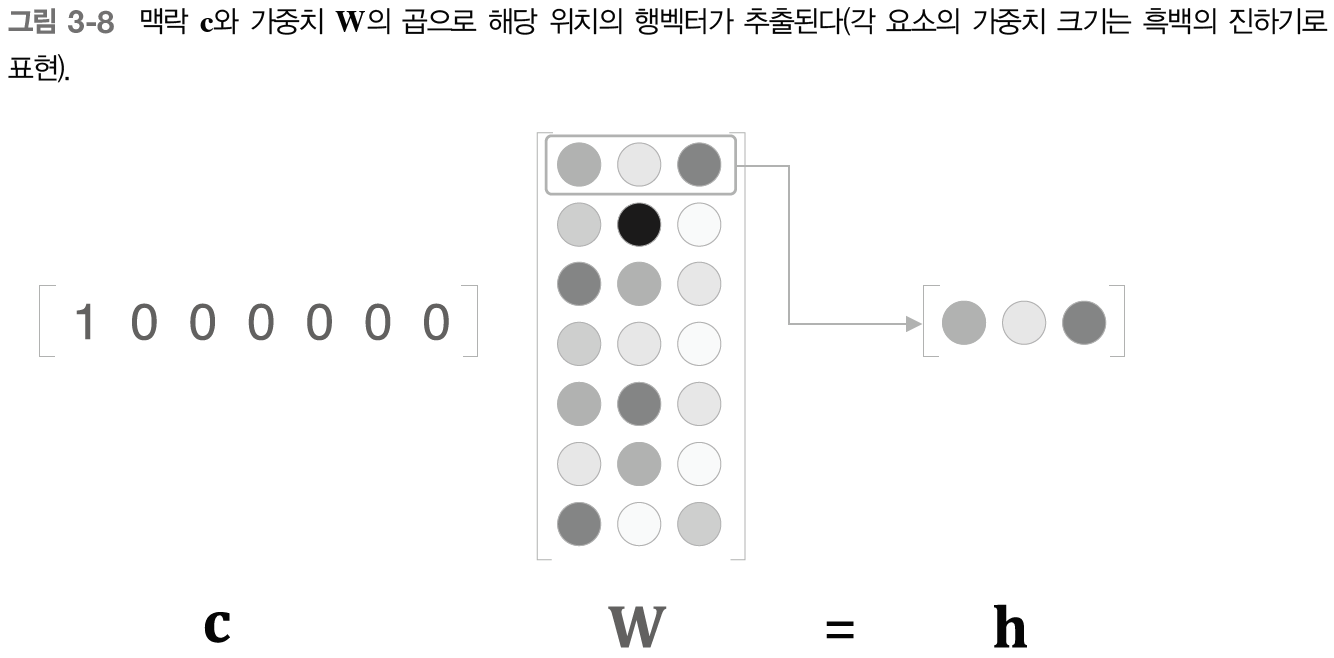

In [5]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 422, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 422 (delta 145), reused 136 (delta 130), pack-reused 236 (from 1)
Receiving objects: 100% (422/422), 7.91 MiB | 20.98 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [6]:
import sys
sys.path.append('/content/deep-learning-from-scratch-2')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.62541584 -0.69000124 -1.3644077 ]]


## 3.2 단순한 word2vec

3.2.1 CBOW 모델의 추론 처리

> CBOW(Continuous Bag-Of-Words) 모델은 맥락(context, 주변 단어)로부터 타깃(target, 중심 단어)을 추측하는 신경망이다.

> CBOW 모델이 가능한 한 정확하게 추론하도록 훈련시켜서 단어의 분산표현을 얻어야 함

> CBOW 모델의 입력은 맥락('you', 'goodbye'와 같은 단어들의 목록)

> 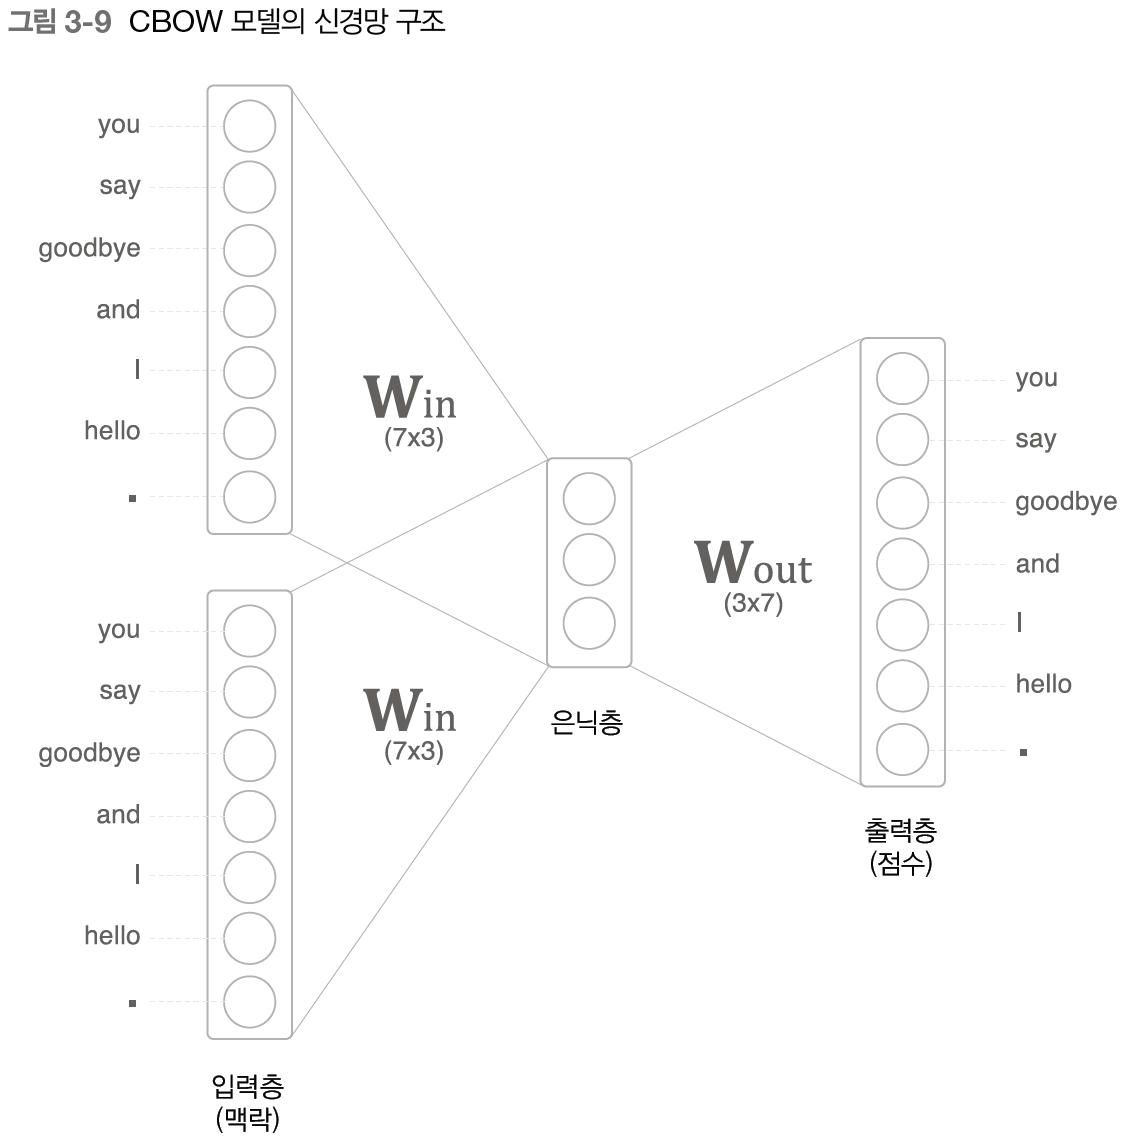


1. 입력층

* 위의 그림에서 입력층이 2개인 이유

> 맥락으로 고려할 단어의 갯수를 2개로 정했기 때문임

> 맥락에 포함시킬 단어의 개수가 n개 라면, 입력층의 갯수도 n개

2. 은닉층

> 은닉층의 뉴런은 입력층의 완전연결계층에 의해 변환된 값이 되는데, CBOW에서는 wiindow_size * 2(C) 개수 만큼 입력이 되므로 전체의 평균(average)을 해준다.

> 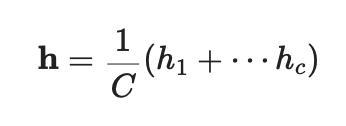

3. 출력층

> 출력층의 뉴런은 총 7개

> 각각의 뉴련이 각각의 단어에 대응함

> 출력층의 뉴런 = 각 단어의 '점수' (점수 : 확률로 해석되기 전의 값)

> softmax(점수) = 확률

> 위의 값이 클수록, 대응 단어의 출현 확률이 높아짐

> 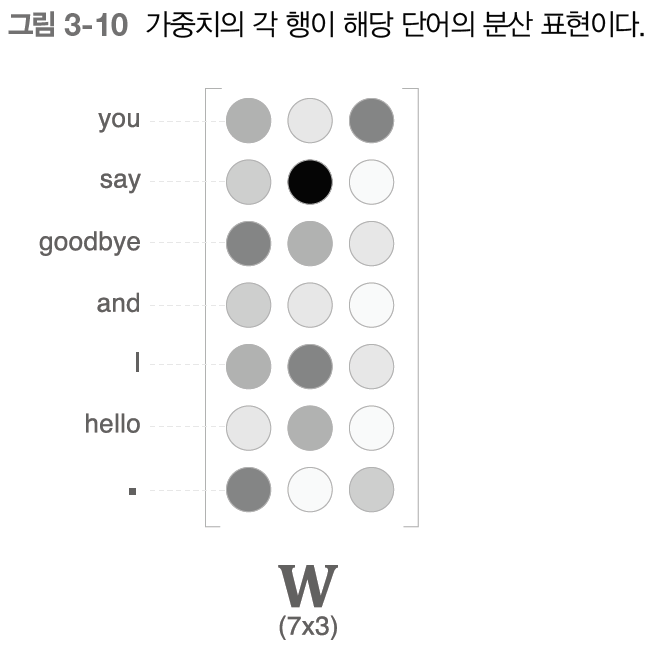

> 입력층에서 은닉층으로의 변환은 완전연결계층(가중치는 $w_{\text{in}}$)에 의해서 이루어짐

> 완전연결계층의 가중치 $w_{\text{in}}$ 은 7x3행렬이고, 이때의 가중치는 단어의 분산 표현의 정체

> 학습을 진행할수록, 맥락에서 출현하는 단어를 잘 추측하는 방향으로 이 분산들의 표현이 갱신될 것

* CBOW 모델을 계층 관점에서 바라보기

>

> 가장 앞단에는 2개의 matmul 계층이 있고, 이 두 계층의 출력이 더해진 값에 0.5를 곱하면 평균이 됨.

> 이 평균이 은닉층의 뉴런이 됨

> 편향을 사용하지 않는 완전연결계층의 처리는 MatMul계층의 순전파와 같음

In [7]:
# CBOW모델의 추론 처리 구현
# chap03/cbow_predict.py
import sys
sys.path.append('/content/deep-learning-from-scratch-2')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)  # average
s = out_layer.forward(h)  # score

print(s)

[[-1.19927115  0.0908062   0.21888455  0.67782663 -0.33077114 -1.91301622
   1.294566  ]]


3.2.2 CBOW 모델의 학습

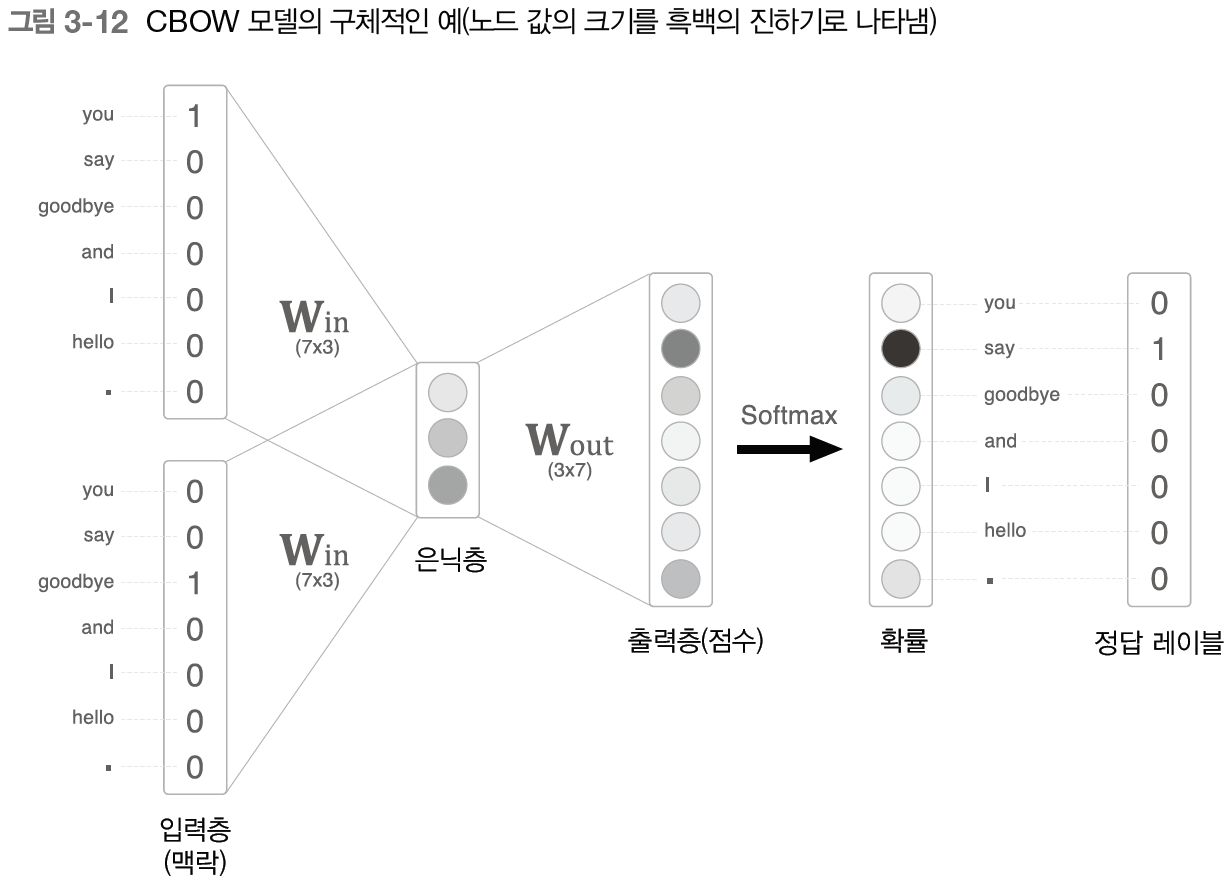

> CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정한다.

> 그 결과 가중치$w_{\text{in}}$ 와 $w_{\text{out}}$에 각 단어의 벡터가 학습된다.

> Word2Vec 모델은 단어 출현 패턴을 학습할 때, 사용한 말뭉치(corpus)로부터 학습한다.

> 그렇기 때문에 말뭉치가 다르면 학습 후 얻게 되는 단어의 분산 표현도 달라진다.

> 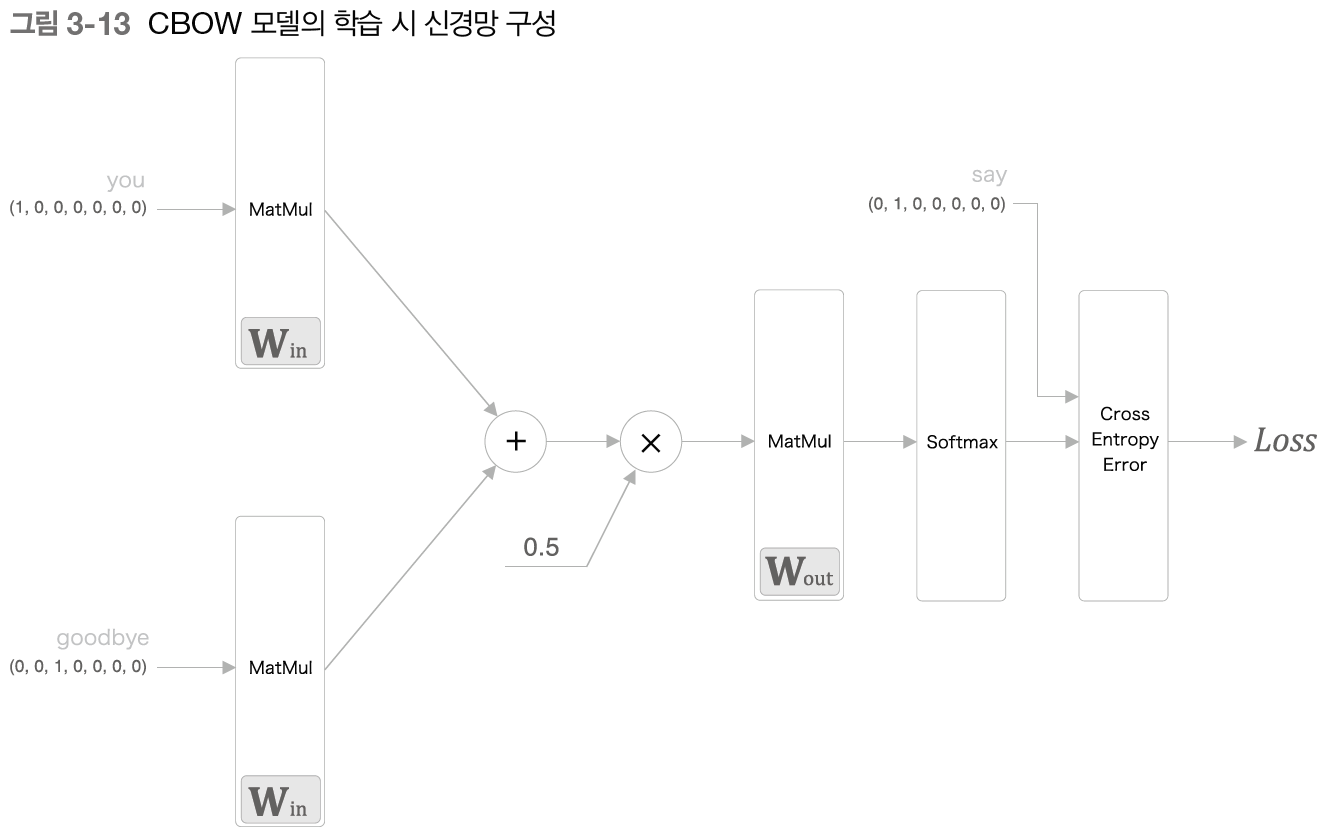

> 우리가 다루는 모델 : 다중 클래스 분류를 수행하는 신경망

> 위의 신경망을 학습하기 위해서는, 소프트맥스와 교차 엔트로피 오차만 이용하면 됨

> 소프트맥스 함수를 이용해서, 점수를 확률로 변환

> 위의 확률과 정답 레이블로부터 교차 엔트로피 오차를 구한 후, 그 값을 손실로 사용해서 학습을 진행


> 그림 3-13에서는 CBOW 모델에 softmax 계층과 cross entropy error 계층을 추가

> 이것을 통해서 손실을 얻을 수 있었음

> 신경망의 순전파

> 2개의 계층을 하나로 합친, Softmax with Loss 라는 하나의 계층으로 구현 가능

> 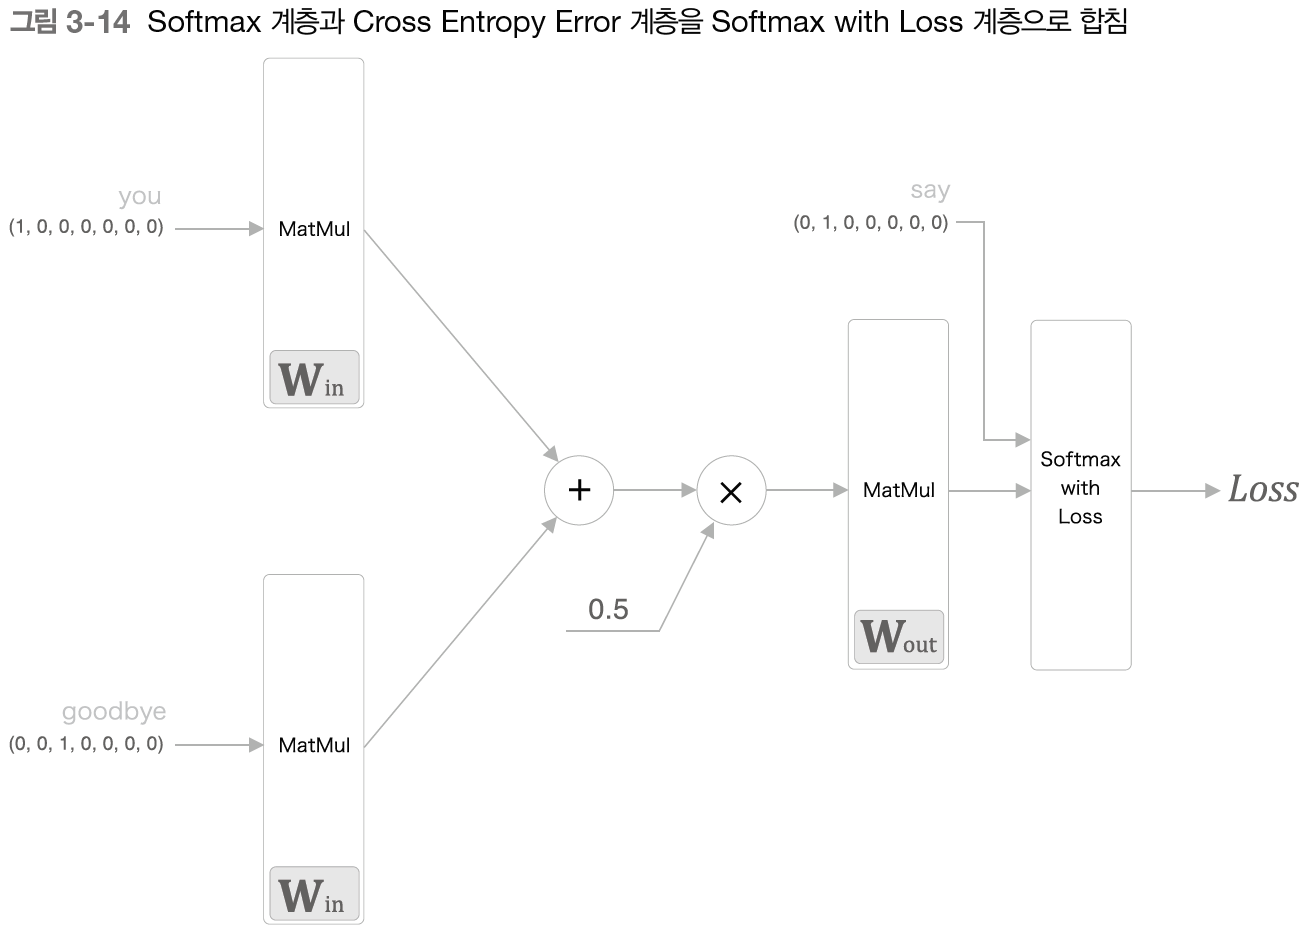

3.2.3 word2vec의 가중치와 분산 표현

> Word2Vec 모델에서는 $w_{\text{in}}$의 각 행(row)과 $w_{\text{out}}$의 각 열(column)이 바로 단어의 분산 표현이 된다.



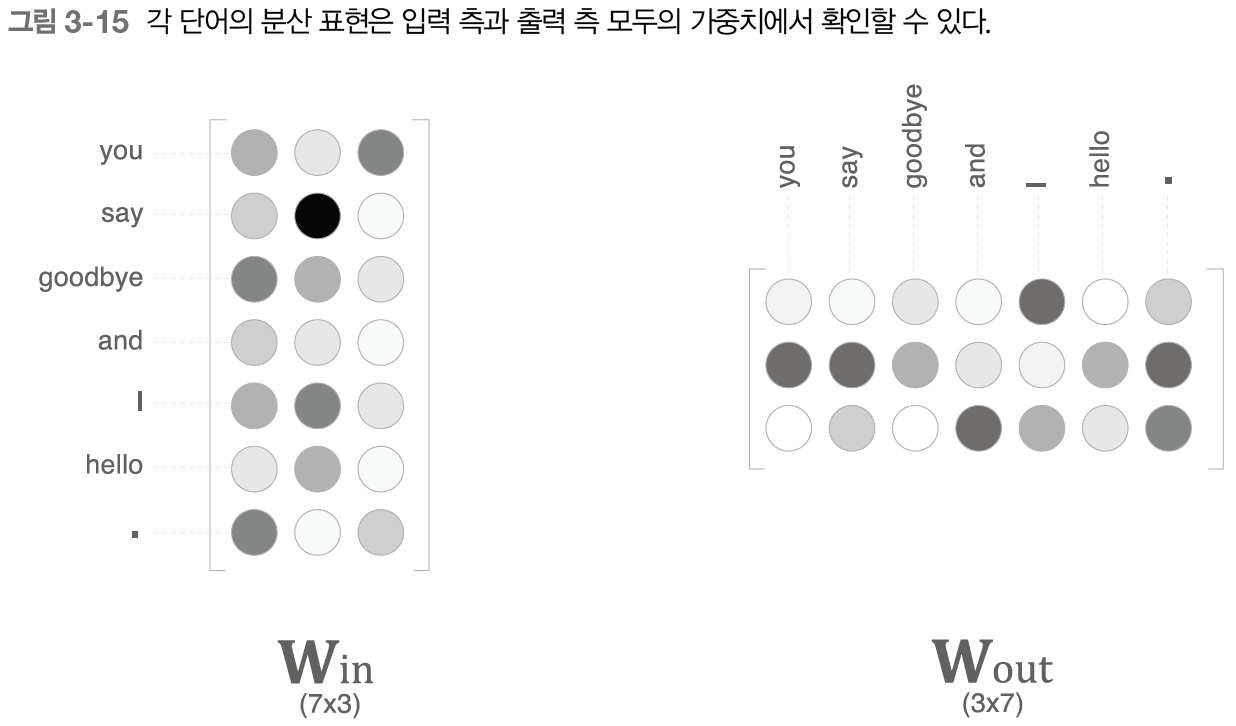

* 최종적으로 이용하는 단어의 분산 표현은 다음과 같이 세 가지 선택 사안이 있다.

1. 입력 측의 가중치($w_{\text{in}}$)만 이용한다.

2. 출력 측의 가중치($w_{\text{out}}$)만 이용한다.

3. 양쪽 가중치를 모두 이용한다. ($w_{\text{in}}$와 $w_{\text{out}}$의 합 등)

> Word2Vec에서 특히 skip-gram 모델에서는 '입력 측의 가중치($w_{\text{in}}$)만 이용한다' 가 가장 대중적인 선택이다.

## 3.3 학습 데이터 준비

3.3.1 맥락과 타깃

> word2vec에서 이용하는 신경망의 입력 > 맥락

> 정답레이블 > 맥락에 둘러싸인 중앙의 단어(타깃)

> 우리가 해야하는 일 : 신경망에 "맥락" 을 입력했을 떄, "타킷" 이 출현할 확률을 높이는 것

> 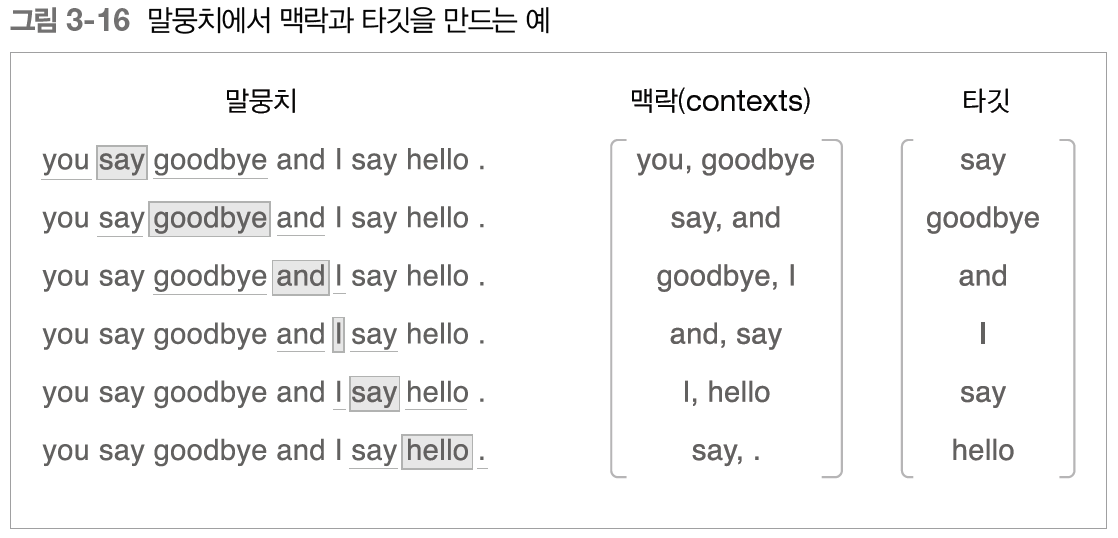

> CBOW 모델에서 입력 데이터인 맥락은 여러개(window_size * 2)가 될 수 있지만, 타깃은 오직하나